In [23]:
""" 
Prepare MIMIC dataset to run deep patient on the dataset
Desired columns: Patient ID, gender, list of ICD codes, mortality
TODO: add more response columns: e.g. number of days in ICU
"""

import collections
import pandas as pd
import sys
from datetime import datetime
import matplotlib.pyplot as plt

In [24]:
""" 
Global parameters
"""
target_diagnosis = "LUNG CA"

In [25]:
"""
Read in ADMISSIONS.csv and construct (1) patient ID to admission ID map, and \
    (2) admission ID to duration in hospital map (in seconds)
"""

pid_admids = {}
admid_duration = {}
admid_diagnosis = {}
admid_type = {}

admission_file = open("../mimiciii/ADMISSIONS.csv", 'r')
admission_file.readline()
for line in admission_file:
    tokens = line.strip().split(',')
    pid = int(tokens[1])
    admid = int(tokens[2])
    diagnosis = tokens[-3]
    adm_type = tokens[6][1:-1]
    if pid in pid_admids: pid_admids[pid].append(admid)
    else: pid_admids[pid] = [admid]

    admit_time = datetime.strptime(tokens[3], '%Y-%m-%d %H:%M:%S')
    discharge_time = datetime.strptime(tokens[4], '%Y-%m-%d %H:%M:%S')
    admid_duration[admid] = (discharge_time-admit_time).total_seconds()
    admid_diagnosis[admid] = diagnosis[1:-1]
    admid_type[admid] = adm_type

admission_file.close()


In [26]:
""" 
Read in PATIENTS.csv and construct admission ID to gender map
"""
admid_gender = {}
patient_file = open("../mimiciii/PATIENTS.csv", 'r')
patient_file.readline()
for line in patient_file:
    tokens = line.strip().split(',')
    pid = int(tokens[1])
    gender = str(tokens[2])
    admids = pid_admids[pid]
    for admid in admids:
        admid_gender[admid] = gender[1]

patient_file.close()

In [27]:
""" 
Consruct admission ID to ICD codes mapping
"""

def convert_to_icd9(dxStr):
    """ 
    Source: https://github.com/mp2893/med2vec/blob/master/process_mimic.py
    I am not sure why ICD codes are converted in this way
    """
    if dxStr.startswith('E'):
        if len(dxStr) > 4: 
            return dxStr[:4] + '.' + dxStr[4:]
        else: 
            return dxStr
    else:
        if len(dxStr) > 3: return dxStr[:3] + '.' + dxStr[3:]
        else: return dxStr

admid_codes = {}
diagnosis_file = open("../mimiciii/DIAGNOSES_ICD.csv", 'r')
diagnosis_file.readline()
for line in diagnosis_file: # read ADMISSIONS.CSV in order
    tokens = line.strip().split(',')
    admid = int(tokens[2])
    dxStr = 'D_' + convert_to_icd9(tokens[4][1:-1]) # 1:-1 to remove quotes

    if admid in admid_codes: 
        admid_codes[admid].append(dxStr)
    else: 
        admid_codes[admid] = [dxStr]

diagnosis_file.close()


In [28]:
"""
Convert str codes to int codes
We use -1 to denote NA code in later analysis
"""

types = {}
for admid, codes in admid_codes.items():
    new_codes = []
    for code in codes:
        if code not in types:
            types[code] = len(types)
        new_codes.append(types[code])
    admid_codes[admid] = new_codes


In [29]:
""" 
Construct a dataframe to store all information including
- patient ID (index key)
- gender
- expire (mortality)
- list of ICD codes
"""

admid_diagnosis_df = pd.DataFrame(columns=['admid', 'adm_type', 'gender','ICD codes','duration', 'diagnosis', 'label'])

for admid, codes in admid_codes.items():
    new_row = {"admid": admid, "adm_type": admid_type[admid], "gender": admid_gender[admid], \
               "duration": admid_duration[admid], "ICD codes": codes, "diagnosis": admid_diagnosis[admid]}
    admid_diagnosis_df = pd.concat([admid_diagnosis_df, pd.DataFrame([new_row])], ignore_index=True)


admid_diagnosis_df = admid_diagnosis_df.set_index('admid')

/home/wanxinli/.local/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [30]:
""" 
Choose lung cancer to be the response
Filter out rows which does not contain target diagnosis in diagnosis
"""
admid_diagnosis_target_df = admid_diagnosis_df.loc[admid_diagnosis_df['diagnosis'].str.contains(target_diagnosis)]
admid_diagnosis_target_df 

,adm_type,gender,ICD codes,duration,diagnosis,label
admid,,,,,,
161473,ELECTIVE,M,"[861, 103, 862, 231, 307, 66, 27, 169, 47]",1910520.0,LUNG CA/SDA,NaN
147743,ELECTIVE,M,"[1530, 103, 45, 66, 61, 93, 109, 58, 1595, 9, ...",2028000.0,LUNG CANCER/SDA,NaN
190712,ELECTIVE,M,"[314, 196, 218, 219, 113, 47, 250, 62, 114]",557400.0,LUNG CA/SDA,NaN
199523,ELECTIVE,M,"[314, 146, 784, 60]",1407000.0,LUNG CA/SDA,NaN
165018,EMERGENCY,M,"[884, 811, 900, 406, 34, 47]",496260.0,LUNG CANCER;HEMOPTYSIS,NaN
...,...,...,...,...,...,...
144869,ELECTIVE,F,"[461, 306, 3974, 2509, 9, 5008, 1836, 887, 886...",806820.0,LUNG CANCER/SDA,NaN
129743,ELECTIVE,M,"[884, 811, 885, 1786, 219, 103, 47, 250, 62, 2...",556800.0,LEFT LUNG CANCER/SDA,NaN
107633,ELECTIVE,M,"[314, 258, 196, 60, 685, 103, 9, 637, 681, 893...",621000.0,LEFT UPPER LOBE LUNG CA/SDA,NaN


In [31]:
""" 
Add target diagnosis label to admid_diagnosis_df
"""
for index, row in admid_diagnosis_df.iterrows():
    if target_diagnosis in row['diagnosis']:
        admid_diagnosis_df.at[index, 'label'] = 1
    else:
        admid_diagnosis_df.at[index, 'label'] = 0

In [32]:
admid_diagnosis_df

,adm_type,gender,ICD codes,duration,diagnosis,label
admid,,,,,,
172335,EMERGENCY,F,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]",530460.0,LEG PAIN,0
173633,EMERGENCY,F,"[0, 14, 15, 6, 16, 10, 11, 9, 17, 18, 19, 20, ...",574560.0,ABDOMINAL PAIN,0
174105,EMERGENCY,M,"[24, 25, 26, 27, 28]",425460.0,GASTROINTESTINAL BLEED,0
109976,EMERGENCY,M,"[29, 30, 31]",1284240.0,HYDROCEPHALUS,0
178393,ELECTIVE,M,"[27, 32, 33, 26, 34, 35]",485280.0,USA/SDA,0
...,...,...,...,...,...,...
172304,ELECTIVE,F,"[256, 385, 760, 47, 34, 31]",449700.0,LEFT BRAIN TUMOR/SDA,0
152542,EMERGENCY,M,"[1736, 1338, 149, 354, 103, 47, 45, 31, 35, 55...",415740.0,PERIRECTAL ABSCESS,0
161999,EMERGENCY,M,"[569, 385, 244, 153, 630, 657, 1088, 44, 2150,...",692940.0,STROKE;TELEMETRY,0


In [33]:
""" 
Plot code distribution for target diagnosis
"""
codes = []
for index, row in admid_diagnosis_target_df.iterrows():
    codes.extend(row['ICD codes'])
        

In [34]:
print(len(codes))

2593


(array([36.,  0.,  0., ...,  0.,  0.,  1.]),
 array([   1,    2,    3, ..., 6910, 6911, 6912]),
 <BarContainer object of 6911 artists>)

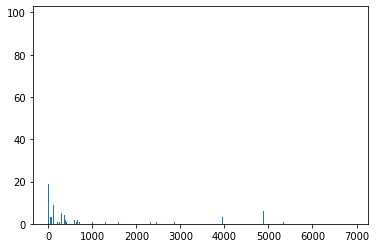

In [35]:

bin_width = 1
plt.hist(codes, bins=range(min(codes), max(codes) + bin_width, bin_width))


In [36]:
code_dict = dict(collections.Counter(codes))

# sort
code_dict = dict(sorted(code_dict.items(), key=lambda item: item[1], reverse=True))
num_top_codes = 50
target_codes = list(code_dict.keys())[:num_top_codes]
print(target_codes)

[47, 103, 314, 461, 93, 273, 884, 156, 62, 811, 1, 34, 31, 219, 885, 250, 45, 99, 9, 306, 137, 26, 27, 313, 43, 5, 78, 37, 685, 1530, 282, 582, 146, 406, 66, 44, 74, 114, 304, 887, 430, 105, 35, 160, 138, 174, 71, 60, 900, 402]


In [37]:
""" 
Filter out code in admid_diagnosis_df  
"""
for index, row in admid_diagnosis_df.iterrows():
    admid_diagnosis_df.at[index, 'ICD codes'] = [code for code in row['ICD codes'] if code in target_codes]


In [38]:
""" 
Filter out row with no ICD codes
"""
admid_diagnosis_df = admid_diagnosis_df[admid_diagnosis_df['ICD codes'].map(len) > 0]


In [39]:
"""
Save dataframe
"""
admid_diagnosis_target_df.to_csv("../../outputs/mimic/ADMID_DIAGNOSIS_TARGET.csv", header=True, index=True)
admid_diagnosis_df.to_csv("../../outputs/mimic/ADMID_DIAGNOSIS.csv", header=True, index=True)


In [40]:
""" 
Calculates the number of males vs females in admid_diagnosis_target_df 
"""
genders = list(admid_diagnosis_target_df['gender'])
print("male number:", genders.count('M'))
print("female number:", genders.count('F'))

male number: 149
female number: 100


In [41]:
""" 
Calculate the number of males vs females, label vs non label in admid_diagnosis_df 
"""
female_ind = 0
female_no_ind = 0
male_ind = 0
male_no_ind = 0

for index, row in admid_diagnosis_df.iterrows():
    if row['label'] and row['gender'] == 'F':
        female_ind += 1
    elif row['label'] and row['gender'] == 'M':
        male_ind += 1
    elif not row['label'] and row['gender'] == 'F':
        female_no_ind += 1
    elif not row['label'] and row['gender'] == 'M':
        male_no_ind += 1

print("female_ind is:", female_ind)
print("female_no_ind is:", female_no_ind)
print("male_ind is:", male_ind)
print("male_no_ind is:", male_no_ind)

print("total number of patients is:", admid_diagnosis_df.shape[0])

female_ind is: 100
female_no_ind is: 20735
male_ind is: 149
male_no_ind is: 26250
total number of patients is: 47234


In [42]:
def vis_emb_dim3_unordered(target_reps, target_labels, source_reps, source_labels, \
    trans_source_reps):
    """ 
    Visualize the embedding space of dimension 3 for target represenatations, source representations, \
        transported source representations with different labels annotated in different colors
    """
    fig = plt.figure()

    ax = fig.add_subplot(1,3,1, projection='3d')
    ax.scatter(target_reps[:, 0], target_reps[:, 1], target_reps[:, 2], c=target_labels)
    ax.set_title("Target")

    ax = fig.add_subplot(1,3,2, projection='3d')
    ax.scatter(source_reps[:, 0], source_reps[:, 1], source_reps[:, 1], c=source_labels)
    ax.set_title("Source")

    ax = fig.add_subplot(1,3,3, projection='3d')
    ax.scatter(trans_source_reps[:, 0], trans_source_reps[:, 1], trans_source_reps[:, 1], c=source_labels)
    ax.set_title("Trans source")
    
    plt.show()
    


In [43]:
vis_emb_dim3_unordered(target_reps, target_labels, source_reps, source_labels, trans_source_reps)

NameError: name 'target_reps' is not defined